# Prokaryotic auto-regulatory gene network Model


In [1]:
# Jax related libraries
import jax.scipy as jsp
import jax.numpy as jnp
import numdifftools as nd
from kalmanODE_jax import *
from jax.config import config
from jax import grad, jit, partial
config.update("jax_enable_x64", True)

# Other libraries
import numpy as np
import scipy as sp
from rodeo.ibm import ibm_init
from rodeo.utils.utils import rand_mat, indep_init, zero_pad
from rodeo.cython.KalmanODE import KalmanODE as KalmanODE_blas
from scipy.integrate import odeint
from proka import proka as inference


# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Save to csv
import pandas as pd

In [2]:
from math import ceil
def theta_plot(kalman_phi, phi_true, var_names, hlist):
    r"Plot the posterior distribution against the true theta."
    kalman_theta = jnp.exp(kalman_phi)
    theta_true = jnp.exp(phi_true)
    n_theta = kalman_theta.shape[2]
    n_plots = kalman_theta.shape[0]
    fig = plt.figure(figsize=(20,10))
    for i in range(n_theta):
        fig.add_subplot(ceil(n_theta/5), min(n_theta,5), i+1)
        for j in range(n_plots):
            sns.kdeplot(kalman_theta[j,:,i], label = hlist[j], legend=False)
        if i < len(theta_true):
            plt.axvline(x=theta_true[i], linewidth=1, color='r', linestyle='dashed')
        plt.title(var_names[i])
    plt.gca().legend(loc='upper right')
    fig.tight_layout()
    plt.close()
    return fig

In [3]:
data_pro = pd.read_csv("gene_autoreg_SDE_50.csv")
deltat = 0.5
Y_t = np.array(data_pro.iloc[:, 1:][::int(deltat/0.01)])

In [50]:
# Convert data to observations at deltat = 0.1
data_pro2 = pd.read_csv("gene_autoreg_Gillespie.csv")
data_pro2['Time'] = np.floor(data_pro2['Time']*2)/2.0
data_pro2 = data_pro2.drop_duplicates(subset='Time', keep='first')
df = pd.DataFrame(np.linspace(0, 50, 101), columns=['Time'])
data_pro2 = df.merge(data_pro2, on='Time',how='left')
data_pro2 = data_pro2.ffill()

deltat = 0.5
Y_t = np.array(data_pro2.iloc[:, 1:])

# SDE Definition

In [4]:
def proka(X_t, t, theta):
    skip = len(X_t)//4
    rna, p, q, dna = X_t[::skip]
    k = 10
    mu0 = theta[2]*dna - theta[6]*rna
    mu1 = 2*theta[5]*q - theta[7]*p + theta[3]*rna - theta[4]*p*(p-1)
    mu2 = theta[1]*(k - dna) - theta[0]*dna*q - theta[5]*q + 0.5*theta[4]*p*(p-1)
    mu3 = theta[1]*(k - dna) - theta[0]*dna*q
    return jnp.stack([mu0, mu1, mu2, mu3])

In [5]:
##### number of derivatives (incl. zero) per variable in ODE-IVP
n_var = 4  # number of variables
n_deriv = [1]*n_var
# W matrix: dimension is n_eq x sum(n_deriv)
W = np.zeros((len(n_deriv), sum(n_deriv) + len(n_deriv)))
for i in range(len(n_deriv)): W[i, sum(n_deriv[:i])+i+1] = 1
x0 = np.array([8, -0.65, 8, 9.6, 8, -4.9, 5, -0.5])
    
# Parameters of the ODE
theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1]) # True theta

# Time interval on which a solution is sought.
tmin = 0 
tmax = 50

# Define the prior process
n_deriv = [1]*n_var # number of derivatives in IVP
n_deriv_prior = [3]*n_var # number of derivatives in IBM prior
p = sum(n_deriv_prior)
state_ind = [0, 3, 6, 9] # Index of each observation

# Pad the inputs
x0 = zero_pad(x0, n_deriv, n_deriv_prior)
W = zero_pad(W, n_deriv, n_deriv_prior)

# IBM process scale factor
scale = [1]*n_var

# Choose small enough step size for good approximation
h = 0.01
n_eval = int((tmax-tmin)/h)

# Instantiate the ODE solver object.
# generate the Kalman parameters corresponding to the prior
prior = ibm_init(h, n_deriv_prior, scale)
prior = indep_init(prior, n_deriv_prior)

# Evaluate the ODE solution
ksim_jax = \
    solve_sim(proka, x0, tmin, tmax, n_eval, W, **prior, theta=theta)

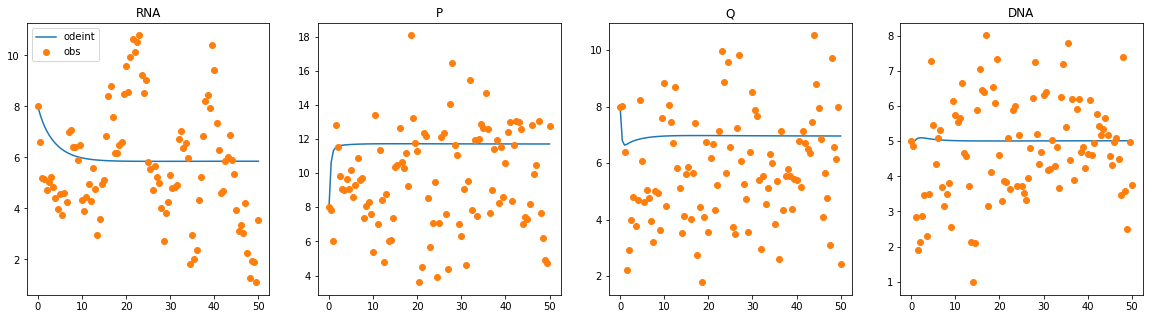

In [6]:
tseq = np.linspace(tmin, tmax, n_eval+1) # Evaluation points
tseq2 = np.linspace(tmin, tmax, 101)
ode = odeint(proka, x0[state_ind], tseq2, args=(theta,))
names = ["RNA", "P", "Q", "DNA"]
# Plot the two solutions
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    #axs[i].plot(tseq, ksim_jax[:,3*i], label='rodeo')
    axs[i].plot(tseq2, ode[:,i], label='odeint')
    axs[i].plot(tseq2, Y_t[:,i], 'o', label='obs')
    axs[i].set_title(names[i])
axs[0].legend(loc='upper left')
plt.show()

We load the observations from a csv file.

In [7]:
n_theta = len(theta)
phi_true = jnp.log(theta) # Convert theta on the log scale
phi_sd = np.log(10)*jnp.ones(n_theta) # Assuming prior is lognormal on true theta
sigma = np.array([None, None, None, None]) # Noise

In [8]:
var_names = ["$\\theta_" + str(i) + "$" for i in range(n_theta)]
var_names.extend(["$\\gamma_" + str(i) + "$" for i in range(n_var)])

In [9]:
# Parameter inference
n_plots = 2
n_samples = 10000
kalman_phi = np.zeros((n_plots, n_samples, n_theta + n_var))
hlist = []
#phi_init = jnp.zeros(n_var+n_theta) -.5
phi_mean = np.zeros(n_theta)
phi_init = jnp.append(phi_true, jnp.zeros(n_var))
for i in range(n_plots):
    h = 0.01/(2**i)
    hlist.append(2**i)
    n_eval = int((tmax-tmin)/h)
    inf = inference(state_ind, tmin, tmax, n_eval, proka, W)
    prior = ibm_init(h, n_deriv_prior, scale)
    prior = indep_init(prior, n_deriv_prior)
    phi_hat, phi_var = inf.phi_fit(Y_t[1:], x0, deltat, h, phi_mean, phi_sd, prior, phi_init=phi_init, sigma=sigma)
    kalman_phi[i] = inf.theta_sample(phi_hat, phi_var, n_samples) # Sample for the posterior

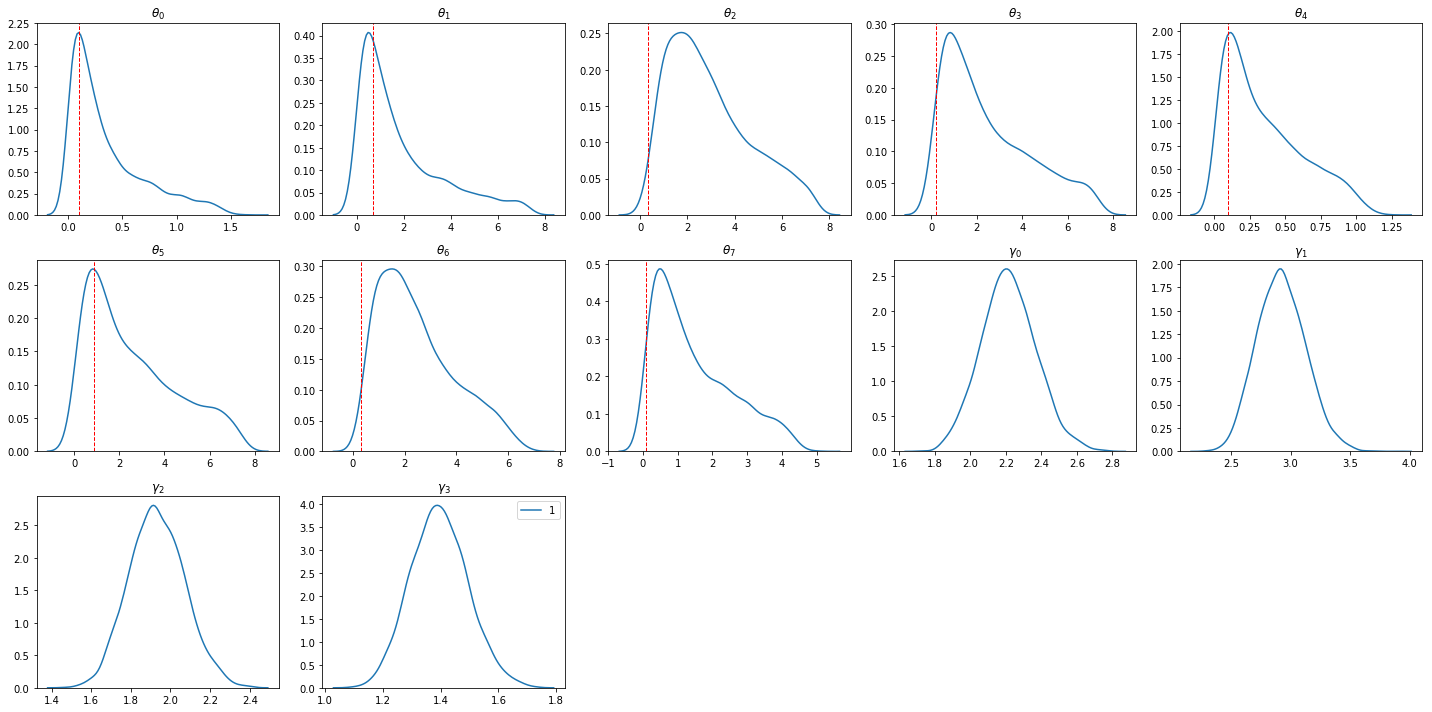

In [13]:
kalman_phi2 = kalman_phi[0:1, np.all(kalman_phi[0]<2, axis=1)]
theta_plot(kalman_phi2[0:1], phi_true, var_names, hlist[0:1])

In [48]:
n_theta = len(theta)
phi_true = jnp.log(theta) # Convert theta on the log scale
phi_sd = jnp.ones(n_theta) # Assuming prior is lognormal on true theta
sigma = np.array([None, None, None, None]) # Noise

In [53]:
# Parameter inference
n_plots = 5
n_samples = 10000
kalman_phi = np.zeros((n_plots, n_samples, n_theta + n_var))
hlist = []
phi_init = jnp.zeros(len(sigma)+n_theta) -.1
for i in range(n_plots):
    h = 0.05/(2**i)
    hlist.append(2**(i))
    n_eval = int((tmax-tmin)/h)
    inf = inference(state_ind, tmin, tmax, n_eval, proka, W)
    prior = ibm_init(h, n_deriv_prior, scale)
    prior = indep_init(prior, n_deriv_prior)
    phi_hat, phi_var = inf.phi_fit(Y_t[1:], x0, deltat, h, phi_true, phi_sd, prior, phi_init=phi_init, sigma=sigma)
    kalman_phi[i] = inf.theta_sample(phi_hat, phi_var, n_samples) # Sample for the posterior

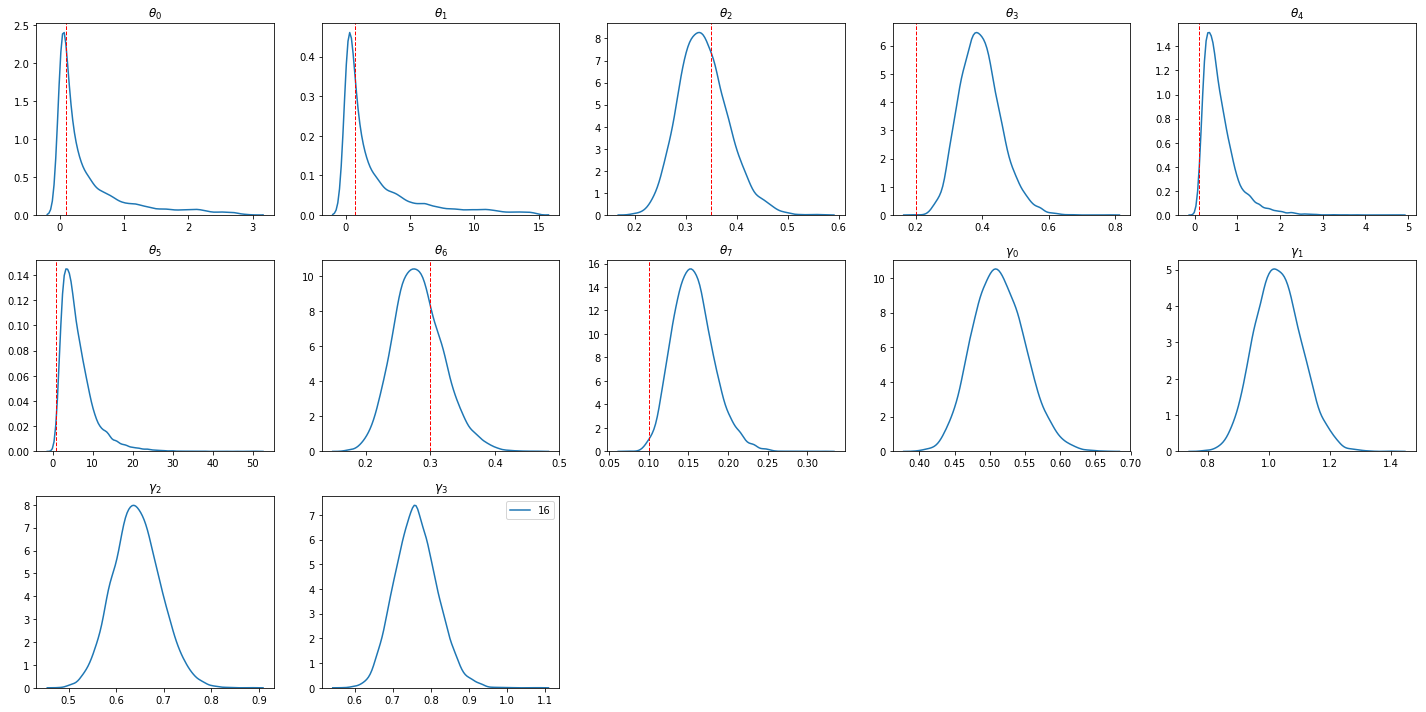

In [62]:
kalman_phi2 = kalman_phi[:, kalman_phi[4, :,1].argsort()][:, :9000]
theta_plot(kalman_phi2[4:5], phi_true, var_names, hlist[4:5])

In [23]:
def logproka(Z_t, t, theta):
    skip = len(Z_t)//4
    X_t = jnp.exp(Z_t)
    rna, p, q, dna = X_t[::skip]
    k = 10
    mu0 = theta[2]*dna/rna - theta[6]
    mu1 = 2*theta[5]*q/p - theta[7] + theta[3]*rna/p - theta[4]*(p-1)
    mu2 = theta[1]*(k - dna)/q - theta[0]*dna - theta[5] + 0.5*theta[4]*p*(p-1)/q
    mu3 = theta[1]*(k - dna)/dna - theta[0]*q
    return jnp.stack([mu0, mu1, mu2, mu3])

In [24]:
from math import log
##### number of derivatives (incl. zero) per variable in ODE-IVP
n_var = 4  # number of variables
n_deriv = [1]*n_var
# W matrix: dimension is n_eq x sum(n_deriv)
W = np.zeros((len(n_deriv), sum(n_deriv) + len(n_deriv)))
for i in range(len(n_deriv)): W[i, sum(n_deriv[:i])+i+1] = 1
x0 = np.array([log(8), -0.65, log(8), 0, log(8), -4.9, log(5), -0.5])
    
# Parameters of the ODE
theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1]) # True theta

# Time interval on which a solution is sought.
tmin = 0 
tmax = 10

# Define the prior process
n_deriv = [1]*n_var # number of derivatives in IVP
n_deriv_prior = [3]*n_var # number of derivatives in IBM prior
p = sum(n_deriv_prior)
state_ind = [0, 3, 6, 9] # Index of each observation

# Pad the inputs
x0 = zero_pad(x0, n_deriv, n_deriv_prior)
W = zero_pad(W, n_deriv, n_deriv_prior)

# IBM process scale factor
scale = [1]*n_var

# Choose small enough step size for good approximation
h = 0.001
n_eval = int((tmax-tmin)/h)

# Instantiate the ODE solver object.
# generate the Kalman parameters corresponding to the prior
prior = ibm_init(h, n_deriv_prior, scale)
prior = indep_init(prior, n_deriv_prior)

# Evaluate the ODE solution
ksim_jax = \
    np.exp(solve_sim(logproka, x0, tmin, tmax, n_eval, W, **prior, theta=theta))